# Introduction

Name : Dinda Tirta Rahayu

Batch 004

In [1]:
from IPython.display import Image
Image(url= "fraud_pic.jpg")

source : https://unsplash.com/photos/gf8e6XvG_3E

# The Problem


We wan to build the model for preditction fraud to improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

In [2]:
from IPython.display import Image
Image(url= "download.png")

source : https://s3.amazonaws.com/integrated-apps/lpvhfkdt/mwtkofun.jpg

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from statistics import mode
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

# Dataset :
    
https://www.kaggle.com/c/ieee-fraud-detection/data

# Data Loading

In [4]:
# Load the train data
train_transaction = pd.read_csv('train_transaction.csv')
train_id = pd.read_csv('train_identity.csv')

In [5]:
# Print the shape and size of data
print('Number of rows in train_transaction data {:,} and number of columns in train_transaction data {:,} '.format(train_transaction.shape[0], train_transaction.shape[1]))
print('Number of rows in train_id data {:,} and number of columns in train_id data {:,} '.format(train_id.shape[0], train_id.shape[1]))


Number of rows in train_transaction data 590,540 and number of columns in train_transaction data 394 
Number of rows in train_id data 144,233 and number of columns in train_id data 41 


# Documentation

# Transaction Table

**Numerical Features:**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.


**Categorical Features:**


- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain


# Identity Table

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

**Categorical Features:**
- DeviceType
- DeviceInfo
- id_12 - id_38

**Identity train**

In [6]:
print(train_id.shape)
print(train_id.info())

(144233, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          1

In [7]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


**Transaction train**

In [8]:
print(train_transaction.shape)
print(train_transaction.info())

(590540, 394)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(362), int64(18), object(14)
memory usage: 1.7+ GB
None


In [9]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Cleaning and Data Preprocessing

In [10]:
print(f'There are {train_transaction.isna().any().sum()} columns with missing values in train transaction data.')
print(f'There are {train_id.isna().any().sum()} columns with missing values in train identity data.')

There are 374 columns with missing values in train transaction data.
There are 38 columns with missing values in train identity data.


# Cleaning - Train identity Data

In [11]:
#build summary table
def buildsummary_(train_id):
    summ = pd.DataFrame(train_id.dtypes, columns=['data type'])
    summ = summ.reset_index()
    summ['cols name'] = summ['index']
    summ = summ[['cols name', 'data type']]
    summ['missing'] = train_id.isna().sum().values
    
    
    summ['unique'] = train_id.nunique().values
        
    return summ

#calling the function to see the summary table
buildsummary_(train_id)[:20]

,cols name,data type,missing,unique
0,TransactionID,int64,0,144233
1,id_01,float64,0,77
2,id_02,float64,3361,115655
3,id_03,float64,77909,24
4,id_04,float64,77909,15
5,id_05,float64,7368,93
6,id_06,float64,7368,101
7,id_07,float64,139078,84
8,id_08,float64,139078,94
9,id_09,float64,69307,46


As we can see in the table, this dataset has a lot of missing values. And we will treat one by one from the column. Almost all columns have missing values ​​which are quite large in number.

In [12]:
# Print %age of null values
total_rows = train_id.shape[0]
columns_to_drop = []
for cols in train_id.columns:
  # check null values
  null_count = train_id[cols].isnull().sum()
  if null_count > 0:
    perc_null_values = float(null_count)*100/total_rows
    print("{} column has {:.3f}% null values".format(cols, perc_null_values))

    if perc_null_values > 50:
      columns_to_drop.append(cols)

id_02 column has 2.330% null values
id_03 column has 54.016% null values
id_04 column has 54.016% null values
id_05 column has 5.108% null values
id_06 column has 5.108% null values
id_07 column has 96.426% null values
id_08 column has 96.426% null values
id_09 column has 48.052% null values
id_10 column has 48.052% null values
id_11 column has 2.257% null values
id_13 column has 11.726% null values
id_14 column has 44.504% null values
id_15 column has 2.252% null values
id_16 column has 10.326% null values
id_17 column has 3.372% null values
id_18 column has 68.722% null values
id_19 column has 3.408% null values
id_20 column has 3.447% null values
id_21 column has 96.423% null values
id_22 column has 96.416% null values
id_23 column has 96.416% null values
id_24 column has 96.709% null values
id_25 column has 96.442% null values
id_26 column has 96.420% null values
id_27 column has 96.416% null values
id_28 column has 2.257% null values
id_29 column has 2.257% null values
id_30 colum

There are about 12 feature columns that contain more than 50% missing values. If the information contained in the variable is not that high, you can drop the variable if it has more than 50% missing values.In this method we are dropping columns with null values ​​above a certain threshold. **Then we will create a threshold of 50% missing values, which means that the 12 columns will be deleted.**

In [13]:
columns_to_drop

['id_03',
 'id_04',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [14]:
# drop the columns to drop
train_id.drop(columns_to_drop, axis=1, inplace=True)

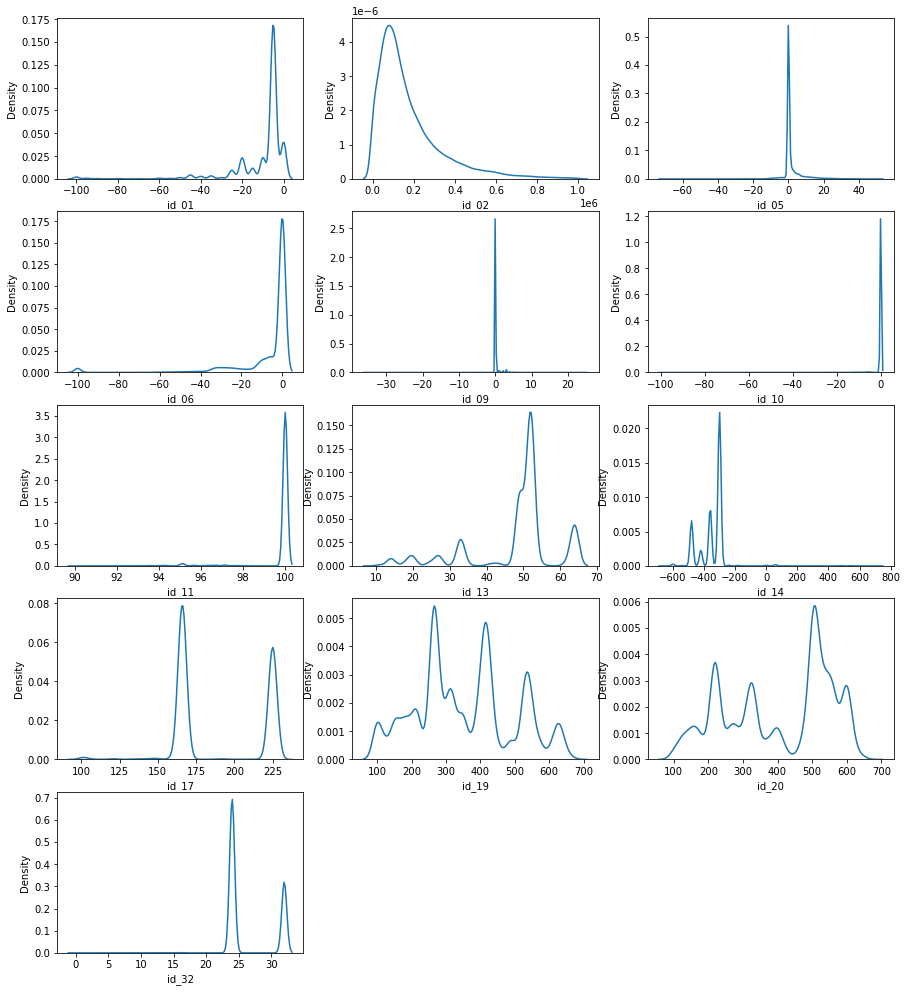

In [15]:
num_cols = [cols for cols in train_id.columns if train_id[cols].dtype == np.number]

plt.figure(figsize=(15,35))
for k, num_cols in enumerate(train_id[num_cols]):
    ax = plt.subplot(10, 3, k+1)
    sns.kdeplot(train_id[num_cols], ax=ax)
plt.show()

In [16]:
train_id.describe()

,TransactionID,id_01,id_02,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32
count,1.442330e+05,144233.000000,140872.000000,136865.000000,136865.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,139318.000000,139261.000000,77586.000000
mean,3.236329e+06,-10.170502,174716.584708,1.615585,-6.698710,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,353.128174,403.882666,26.508597
std,1.788496e+05,14.347949,159651.816856,5.249856,16.491104,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,141.095343,152.160327,3.737502
min,2.987004e+06,-100.000000,1.000000,-72.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,100.000000,100.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,-6.000000,0.000000,0.000000,100.000000,49.000000,-360.000000,166.000000,266.000000,256.000000,24.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,166.000000,341.000000,472.000000,24.000000
75%,3.392923e+06,-5.000000,228749.000000,1.000000,0.000000,0.000000,0.000000,100.000000,52.000000,-300.000000,225.000000,427.000000,533.000000,32.000000
max,3.577534e+06,0.000000,999595.000000,52.000000,0.000000,25.000000,0.000000,100.000000,64.000000,720.000000,229.000000,671.000000,661.000000,32.000000


Before we specify to treat missing values ​​in the train_id data. We can analyze the graph of the distribution of the distribution per each variable. And we get the conclusion that all numerical data in this data is **right-skewed and left-skewed.** This means that the data does not have a normal distribution. **So we will add the median of the per column variables to fill in the blank data.**

**Treat Missing Values in Numerical Features**

In [17]:
# fill  the rest of nan with default values
num_cols = [cols for cols in train_id.columns if train_id[cols].dtype == np.number]


for col in num_cols:
    train_id[col] = train_id[col].fillna(train_id[col].median(), axis=0)

**Treat Missing Values in Categorical Features**

In [18]:
# label encode the categorical columns
cat_cols = [cols for cols in train_id.columns if train_id[cols].dtype == 'object']

# Label Encoder object
le = LabelEncoder()
for col in cat_cols:
    train_id[col] = train_id[col].astype('str')
    train_id[col] = le.fit_transform(train_id[col])
    train_id[col] = train_id[col].fillna(train_id[col].mode()[0], axis=0)

For the technique of filling in empty values in categorical columns, a common thing is to **add the mode value of each column.** **So here we can apply the technique.**


Here we go!

In [19]:
train_id

,TransactionID,id_01,id_02,id_05,id_06,id_09,id_10,id_11,id_12,id_13,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,0.0,0.0,0.0,0.0,100.0,1,52.0,...,124,32.0,164,3,1,0,1,1,1,954
1,2987008,-5.0,98945.0,0.0,-5.0,0.0,0.0,100.0,1,49.0,...,98,32.0,48,2,1,0,0,1,1,1727
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,100.0,1,52.0,...,44,24.0,260,4,0,0,1,1,0,1598
3,2987011,-5.0,221832.0,0.0,-6.0,0.0,0.0,100.0,1,52.0,...,44,24.0,260,4,0,0,1,1,0,1742
4,2987016,0.0,7460.0,1.0,0.0,0.0,0.0,100.0,1,52.0,...,44,24.0,40,3,1,0,1,1,0,723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,100.0,1,27.0,...,57,24.0,260,4,0,0,1,0,1,276
144229,3577526,-5.0,172059.0,1.0,-5.0,0.0,0.0,100.0,1,27.0,...,31,32.0,255,3,1,0,1,0,1,65
144230,3577529,-20.0,632381.0,-1.0,-36.0,0.0,0.0,100.0,1,27.0,...,54,24.0,260,4,0,0,1,0,1,748
144231,3577531,-5.0,55528.0,0.0,-7.0,0.0,0.0,100.0,1,27.0,...,56,24.0,183,3,1,0,1,0,0,723


In [20]:
#checking miss val again
train_id.isna().sum()

TransactionID    0
id_01            0
id_02            0
id_05            0
id_06            0
id_09            0
id_10            0
id_11            0
id_12            0
id_13            0
id_14            0
id_15            0
id_16            0
id_17            0
id_19            0
id_20            0
id_28            0
id_29            0
id_30            0
id_31            0
id_32            0
id_33            0
id_34            0
id_35            0
id_36            0
id_37            0
id_38            0
DeviceType       0
DeviceInfo       0
dtype: int64

# Cleaning - Train Transaction Data

In [21]:
#build summary table
def buildsummary(train_transaction):
    summ = pd.DataFrame(train_transaction.dtypes, columns=['data type'])
    summ = summ.reset_index()
    summ['cols name'] = summ['index']
    summ = summ[['cols name', 'data type']]
    summ['missing'] = train_transaction.isna().sum().values
    
    
    summ['unique'] = train_transaction.nunique().values
        
    return summ

#calling the function to see the summary table
buildsummary(train_transaction)[:20]

,cols name,data type,missing,unique
0,TransactionID,int64,0,590540
1,isFraud,int64,0,2
2,TransactionDT,int64,0,573349
3,TransactionAmt,float64,0,20902
4,ProductCD,object,0,5
5,card1,int64,0,13553
6,card2,float64,8933,500
7,card3,float64,1565,114
8,card4,object,1577,4
9,card5,float64,4259,119


Next on the train_transaction data we will treat missing values ​​with the same technique as the train_id data :

1. Using 50% threshold missing values, columns that exceed the threshold will be removed.


2. Using the median to fill in the missing values ​​in the numerical data, because the majority of numerical data distribution is non-normal distribution.


3. Using the technique of filling mode values ​​on missing values ​​in categorical data.

In [22]:
# print percentage of null values in the transaction data
# Print %age of null values
total_rows = train_transaction.shape[0]
columns_to_drop = []
for cols in train_transaction.columns:
  # check null values
  null_count = train_transaction[cols].isnull().sum()
  if null_count > 0:
    perc_null_values = float(null_count)*100/total_rows
    print("{} column has {:.3f}% null values".format(cols, perc_null_values))

    if perc_null_values > 50:
      columns_to_drop.append(cols)

card2 column has 1.513% null values
card3 column has 0.265% null values
card4 column has 0.267% null values
card5 column has 0.721% null values
card6 column has 0.266% null values
addr1 column has 11.126% null values
addr2 column has 11.126% null values
dist1 column has 59.652% null values
dist2 column has 93.628% null values
P_emaildomain column has 15.995% null values
R_emaildomain column has 76.752% null values
D1 column has 0.215% null values
D2 column has 47.549% null values
D3 column has 44.515% null values
D4 column has 28.605% null values
D5 column has 52.467% null values
D6 column has 87.607% null values
D7 column has 93.410% null values
D8 column has 87.312% null values
D9 column has 87.312% null values
D10 column has 12.873% null values
D11 column has 47.293% null values
D12 column has 89.041% null values
D13 column has 89.509% null values
D14 column has 89.469% null values
D15 column has 15.090% null values
M1 column has 45.907% null values
M2 column has 45.907% null values

In [23]:
len(columns_to_drop)

174

In [24]:
# drop the columns to drop
train_transaction.drop(columns_to_drop, axis=1, inplace=True)

**Treat Numerical Missing Values**

In [25]:
num_cols = [cols for cols in train_transaction.columns if train_transaction[cols].dtype == np.number]

for col in num_cols:
    train_transaction[col] = train_transaction[col].fillna(train_transaction[col].median(), axis=0)

In [26]:
# Encode the categorical cols
cat_cols2 = [cols for cols in train_transaction.columns if train_transaction[cols].dtype == 'object']
for cols in cat_cols2:
    le = LabelEncoder()
    train_transaction[cols] = train_transaction[cols].astype('str')
    train_transaction[cols] = le.fit_transform(train_transaction[cols])

In [27]:
train_transaction

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.50,4,13926,361.0,150.0,1,142.0,...,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000
1,2987001,0,86401,29.00,4,2755,404.0,150.0,2,102.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2987002,0,86469,59.00,4,4663,490.0,150.0,4,166.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,2987003,0,86499,50.00,4,18132,567.0,150.0,2,117.0,...,135.0,0.000000,0.000000,0.000000,50.0,1404.0,790.0,0.000000,0.000000,0.000000
4,2987004,0,86506,50.00,1,4497,514.0,150.0,2,102.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,4,6550,361.0,150.0,4,226.0,...,0.0,47.950001,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000
590536,3577536,0,15811049,39.50,4,10444,225.0,150.0,2,224.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
590537,3577537,0,15811079,30.95,4,12037,595.0,150.0,2,224.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
590538,3577538,0,15811088,117.00,4,7826,481.0,150.0,2,224.0,...,117.0,317.500000,669.500000,317.500000,0.0,2234.0,0.0,0.000000,0.000000,0.000000


In [28]:
#checking missing values again
train_transaction.isnull().sum()

TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
                 ..
V317              0
V318              0
V319              0
V320              0
V321              0
Length: 220, dtype: int64

# Merge - Data Train

In [29]:
# merge both the dataset
final_data = pd.merge(train_id, train_transaction, on='TransactionID', how='inner')

In [30]:
final_data.head()

,TransactionID,id_01,id_02,id_05,id_06,id_09,id_10,id_11,id_12,id_13,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987004,0.0,70787.0,0.0,0.0,0.0,0.0,100.0,1,52.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2987008,-5.0,98945.0,0.0,-5.0,0.0,0.0,100.0,1,49.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,100.0,1,52.0,...,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497
3,2987011,-5.0,221832.0,0.0,-6.0,0.0,0.0,100.0,1,52.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2987016,0.0,7460.0,1.0,0.0,0.0,0.0,100.0,1,52.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000


# Data Exploration 

In [31]:
final_data.describe()

,TransactionID,id_01,id_02,id_05,id_06,id_09,id_10,id_11,id_12,id_13,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,1.442330e+05,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,...,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000,144233.000000
mean,3.236329e+06,-10.170502,173576.714077,1.533054,-6.356513,0.047285,-0.156427,99.751072,0.852960,48.515894,...,18.358382,8.010673,16.346129,8.812031,374.481096,675.687721,507.472289,30.226226,80.569151,54.806776
std,1.788496e+05,14.347949,157953.174190,5.126361,16.131925,0.710557,2.016105,1.115447,0.354147,11.135605,...,213.234033,43.522359,89.909609,47.900108,4555.363355,7658.228995,5571.124525,612.150830,870.839348,704.063932
min,2.987004e+06,-100.000000,1.000000,-72.000000,-100.000000,-36.000000,-100.000000,90.000000,0.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.077142e+06,-10.000000,69271.000000,0.000000,-5.000000,0.000000,0.000000,100.000000,1.000000,49.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000,52.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.392923e+06,-5.000000,225093.000000,1.000000,0.000000,0.000000,0.000000,100.000000,1.000000,52.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.577534e+06,0.000000,999595.000000,52.000000,0.000000,25.000000,0.000000,100.000000,1.000000,64.000000,...,55125.000000,3300.000000,3300.000000,3300.000000,93736.000000,134021.000000,98476.000000,104060.000000,104060.000000,104060.000000


# Summary


1. Almost all of the data in the final data have a mean > median so that they experience a non-normal distribution with different data scales in each column.


2. There is a column that has a negative value (-) namely column id_01.


3. In this final data, we convert all categorical data using LabelEncoder because my device does not support One Hot Encode. There will be more than 2000 features when using One Hot Encode.


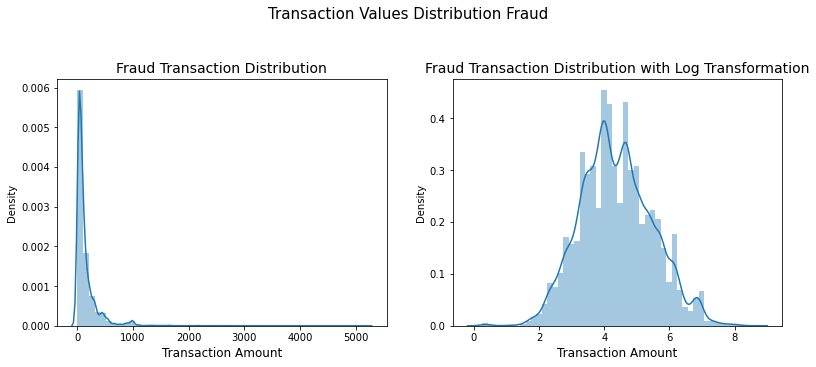

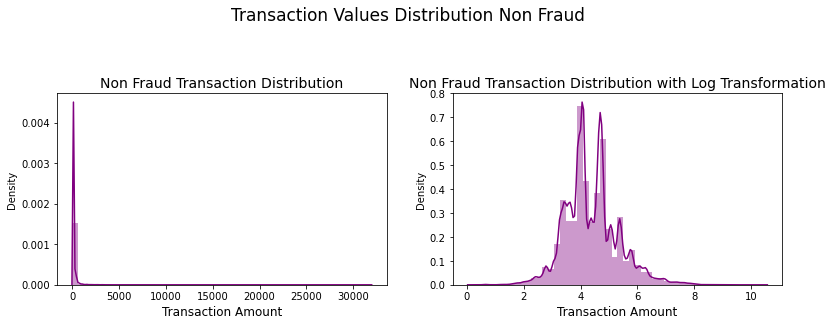

In [32]:
#transaction amount plotting
plt.figure(figsize=(13,10))
#Fraud no transformation
plt.subplot(221)
plt.suptitle('Transaction Values Distribution Fraud', fontsize=15)
ax0 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values, kde=True, hist=True)
ax0.set_title('Fraud Transaction Distribution', fontsize=14)
ax0.set_xlabel('Transaction Amount', fontsize=12)

#fraud with transformation
plt.subplot(222)
ax1 = sns.distplot(np.log((train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values)+1), kde=True, hist=True)
ax1.set_title('Fraud Transaction Distribution with Log Transformation', fontsize=14)
ax1.set_xlabel('Transaction Amount', fontsize=12)

#non fraud no transformation
plt.figure(figsize=(13,12))
plt.subplot(321)
plt.suptitle('Transaction Values Distribution Non Fraud', fontsize=17)
ax2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values, kde=True, hist=True, color='purple')
ax2.set_title('Non Fraud Transaction Distribution', fontsize=14)
ax2.set_xlabel('Transaction Amount', fontsize=12)

#non fraud with transformation
plt.subplot(322)
ax3 = sns.distplot(np.log((train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values)+1), kde=True, hist=True, color='purple')
ax3.set_title('Non Fraud Transaction Distribution with Log Transformation', fontsize=14)
ax3.set_xlabel('Transaction Amount', fontsize=12)
plt.show()


It can be seen in the graph above that there is a transaction amount column which is distributed with the division of fraud and non-fraud. **The transaction amount in the fraud distribution has a distribution with a range of transactions made by consumers from Vesta Corporation's e-commerce, from 0-5000 USD and density up to 0.006. Meanwhile, the distribution of non-fraud transaction amounts by e-commerce users of Vesta Corporation is in the range of 0-3000 USD. And density up to 0.004.** But when we compare it with a distribution that has been transformed very far, the distribution with the transformation has a normal / gaussian distribution. And a high density range.

In the graph above, it can be concluded as follows:


1. 0, 1 and 2 are the most frequent values.


2. We can note that in 1, 2 and 3 the distribution of Fraud values are slightly higher than the Non-Fraud Transactions. 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


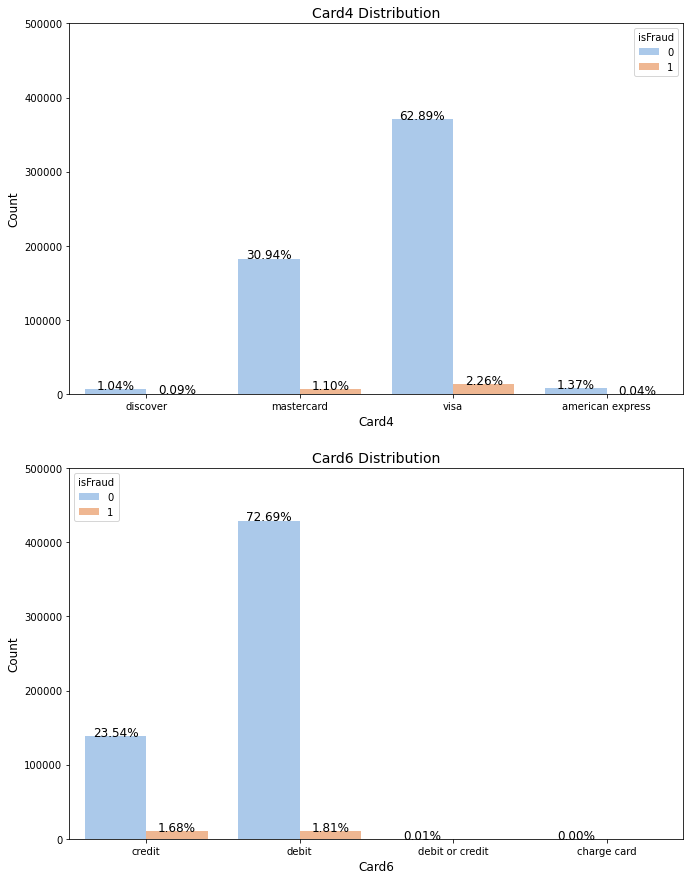

In [17]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(11,15))

plt.subplot(211)
p = sns.countplot(x='card4', data=card_iden, hue='isFraud', palette='pastel')
p.set_title("Card4 Distribution", fontsize=14)
p.set_xlabel("Card4", fontsize=12)
p.set_ylabel("Count", fontsize=12)
p.set_ylim(0,500000)
for e in p.patches:
    height = e.get_height()
    p.text(e.get_x()+e.get_width()/2.,
            height + 3, '{:1.2f}%'.format(height/len(card_iden)*100),
            ha="center", fontsize=12) 

plt.subplot(212)
p1 = sns.countplot(x='card6', data=card_iden, hue='isFraud', palette='pastel')
p1.set_title("Card6 Distribution", fontsize=14)
p1.set_xlabel("Card6", fontsize=12)
p1.set_ylabel("Count", fontsize=12)
p1.set_ylim(0,500000)
for f in p1.patches:
    height = f.get_height()
    p1.text(f.get_x()+f.get_width()/2.,
            height + 3, '{:1.2f}%'.format(height/len(card_iden)*100),
            ha="center", fontsize=12) 


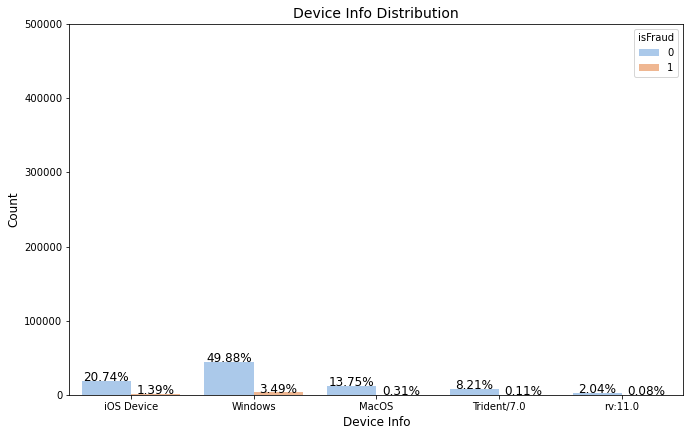

In [22]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(11,15))

plt.subplot(211)
p = sns.countplot(x=df_filtered['DeviceInfo'], hue=df_filtered['isFraud'], palette='pastel')
p.set_title("Device Info Distribution", fontsize=14)
p.set_xlabel("Device Info", fontsize=12)
p.set_ylabel("Count", fontsize=12)
p.set_ylim(0,500000)
for e in p.patches:
    height = e.get_height()
    p.text(e.get_x()+e.get_width()/2.,
            height + 3, '{:1.2f}%'.format(height/len(df_filtered)*100),
            ha="center", fontsize=12) 

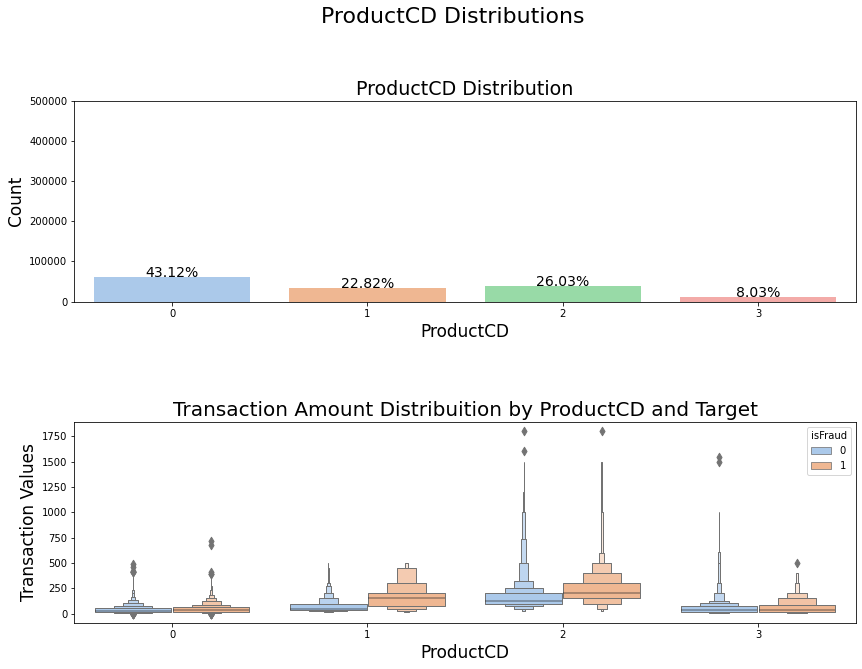

In [33]:
plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)


plt.subplot(211)
p = sns.countplot(x='ProductCD', data=final_data, palette='pastel')
p.set_title("ProductCD Distribution", fontsize=19)
p.set_xlabel("ProductCD", fontsize=17)
p.set_ylabel("Count", fontsize=17)
p.set_ylim(0,500000)
for e in p.patches:
    height = e.get_height()
    p.text(e.get_x()+e.get_width()/2.,
            height + 3, '{:1.2f}%'.format(height/len(final_data)*100),
            ha="center", fontsize=14) 


plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=final_data[final_data['TransactionAmt'] <= 2000], palette='pastel')
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

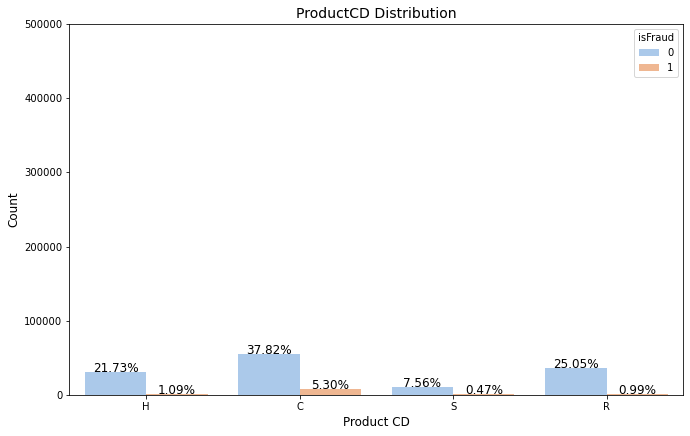

In [24]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(11,15))

plt.subplot(211)
p = sns.countplot(x=final_data['ProductCD'], hue=final_data['isFraud'], palette='pastel')
p.set_title("ProductCD Distribution", fontsize=14)
p.set_xlabel("Product CD", fontsize=12)
p.set_ylabel("Count", fontsize=12)
p.set_ylim(0,500000)
for e in p.patches:
    height = e.get_height()
    p.text(e.get_x()+e.get_width()/2.,
            height + 3, '{:1.2f}%'.format(height/len(final_data)*100),
            ha="center", fontsize=12) 

Text(0.5, 0, 'Class')

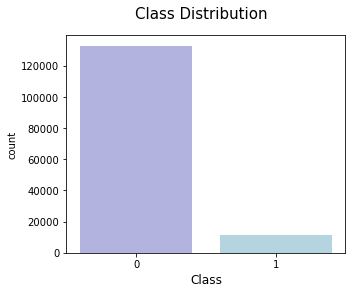

In [34]:
#class distribution plotting
plt.figure(figsize=(5,4))
plt.suptitle('Class Distribution', fontsize=15)
p1 = sns.countplot(final_data['isFraud'], palette=['#acace6', '#add8e6'])
p1.set_xlabel('Class', fontsize=12)


It is clear from the class distribution above that it can be seen that the target class is experiencing data imbalance. Because our goal is to predict fraud so we need to treat the imbalance data to balance it, we will use the **SMOTE method** in the next step.

# Feature Important

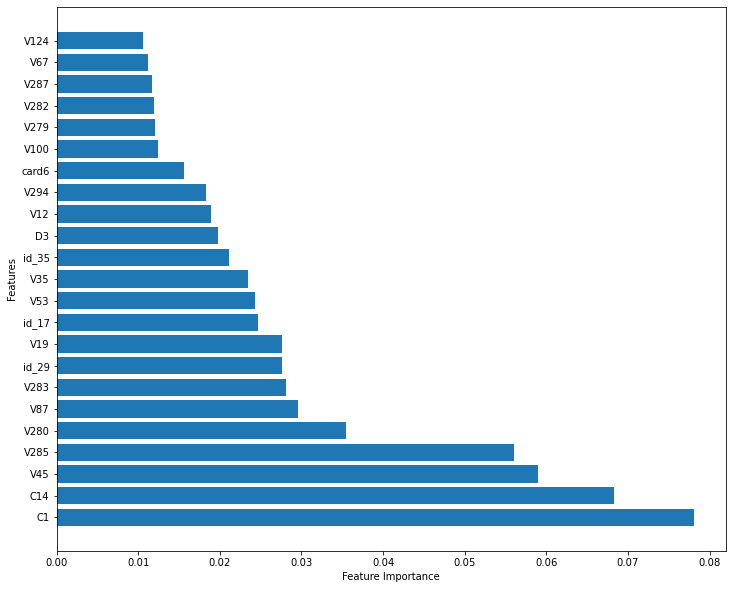

In [47]:
# print the feature importance
features = X.columns
feature_imp = xgb_clf.feature_importances_

feat_imp_df = pd.DataFrame({'Features' : features, 'Feature_Importance' : feature_imp}).sort_values(by='Feature_Importance', ascending=False)

# Plot the feature_importance : only top 10
plt.figure(figsize=(12,10))
plt.barh(y=feat_imp_df['Features'].iloc[ :23], width=feat_imp_df['Feature_Importance'].iloc[ :23])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

In [53]:
feat_imp_df['Features'][:23].values

array(['C1', 'C14', 'V285', 'V287', 'id_17', 'V100', 'V19', 'V12', 'V124',
       'V67', 'V294', 'V45', 'V87', 'card6', 'V53', 'V35', 'V282', 'V283',
       'V279', 'id_35', 'D3', 'V280', 'id_29'], dtype=object)

# Model Definition

In [36]:
final_data = final_data[['C1', 'C14', 'V45', 'V285', 'V280', 'V87', 'V283', 'id_29', 'V19',
       'id_17', 'V53', 'V35', 'id_35', 'D3', 'V12', 'V294', 'card6',
       'V100', 'V279', 'V282', 'V287', 'V67', 'V124', 'isFraud']]

In [37]:
# split the dataset into train features and target varaible
X = final_data.drop('isFraud', axis=1)
y = final_data['isFraud']

In [38]:
# split the tdata
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Create StratifiedKFold object.
xgb_clf = XGBClassifier()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.values[train_index], X.values[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    xgb_clf.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(xgb_clf.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

[21:23:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:24:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:24:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

# SMOTE

In [40]:
#SMOTE METHOD
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y)
print('Before :', counter)

#Oversampling of the dataset using SMOTE
smt = SMOTE()
X_smote, y_smote = smt.fit_resample(X_train, y_train)

counter = Counter(y_smote)
print('After :', counter)

Before : Counter({0: 132915, 1: 11318})
After : Counter({0: 106328, 1: 106328})


# Model Definition

In [42]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_smote, y_smote)

[21:25:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_smote, y_smote)

RandomForestClassifier()

# Model Evaluation

**XGBoost Classifier**

In [43]:
# Compute classification report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score
prediction = xgb_clf.predict(X_val)
print(classification_report(y_val, prediction))
print(accuracy_score(y_val, prediction))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     26587
           1       0.46      0.74      0.57      2260

    accuracy                           0.91     28847
   macro avg       0.72      0.83      0.76     28847
weighted avg       0.94      0.91      0.92     28847

0.9104586265469546


**Random Forest Classifier**

In [57]:
# Compute classification report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score
prediction_rf = rf.predict(X_val)
print(classification_report(y_val, prediction_rf))
print(accuracy_score(y_val, prediction_rf))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     26587
           1       0.45      0.73      0.56      2260

    accuracy                           0.91     28847
   macro avg       0.71      0.83      0.75     28847
weighted avg       0.93      0.91      0.92     28847

0.9083093562588831


In [50]:
# Compute ROC AUC Score
prediction_probability = xgb_clf.predict_proba(X_val)
print(roc_auc_score(y_val, prediction_probability[ : , 1]))

0.9143987713071563


<Figure size 720x504 with 0 Axes>

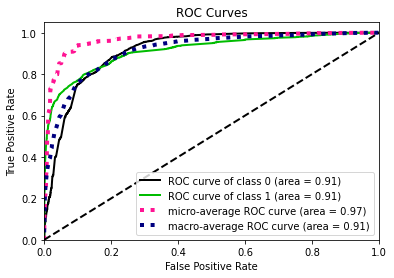

In [51]:
import scikitplot as skplt

plt.figure(figsize=(10,7))
skplt.metrics.plot_roc_curve(y_val, prediction_probability )
plt.show()

In [52]:
# Make predictions on train and test set
pred_train = xgb_clf.predict_proba(X_smote)
pred_test = xgb_clf.predict_proba(X_val)

print('Train set')
print('XGBoost roc-auc: {}'.format(roc_auc_score(y_smote, pred_train[:,1])))
print('Test set')
print('XGBoost roc-auc: {}'.format(roc_auc_score(y_val, pred_test[:,1])))

Train set
XGBoost roc-auc: 0.9599977791940977
Test set
XGBoost roc-auc: 0.9143987713071563


<AxesSubplot:>

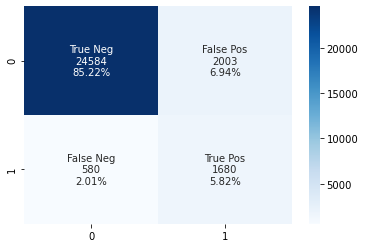

In [53]:
#Get the confusion matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

cf_matrix_rf = confusion_matrix(y_val, prediction)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_rf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_rf.flatten()/np.sum(cf_matrix_rf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix_rf, annot=labels, fmt='', cmap='Blues')

In this fraud detection model, we want to avoid farud in transactions. So we want to minimize false negatives, i.e. data that is predicted to be not fraudulent but actually fraudulent. The data is fraudulent but is predicted not to be fraudulent. This will be very detrimental to e-commerce companies and also sellers in e-commerce.

**Here we get a result of 2.01% False negative. This figure is still quite large, because when there were 28847 transactions, there were 580 transactions that were predicted not to be fraudulent even though they should have been fraudulent.**

# Model Inference

In [49]:
test_transaction = pd.read_csv('test_transaction.csv')
test_id = pd.read_csv('test_identity.csv')

In [50]:
# merge both the dataset
data_test = pd.merge(test_id, test_transaction, on='TransactionID', how='inner')

In [51]:
data_test = final_data[:1000]
data_test = data_test.drop(['isFraud'], axis=1)

In [ ]:
# Compute classification report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score
prediction_test = xgb_clf.predict(data_test, validate_features=False)

In [ ]:
print(prediction_test)

# Pipeline

In [54]:
from sklearn.pipeline import make_pipeline
# abbreviated syntax
pipe = make_pipeline(XGBClassifier())

In [55]:
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('xgbclassifier', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None))]


In [56]:
pipe.fit(X_smote, y_smote)

[15:34:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [57]:
# Compute classification report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score
prediction = pipe.predict(X_val)
print(classification_report(y_val, prediction))
print(accuracy_score(y_val, prediction))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     26587
           1       0.47      0.74      0.57      2260

    accuracy                           0.91     28847
   macro avg       0.72      0.83      0.76     28847
weighted avg       0.94      0.91      0.92     28847

0.9131278815821403


# Model Saving

In [58]:
import joblib
joblib.dump(pipe, 'model_milestone_2.pkl')
final_model_loaded = joblib.load('model_milestone_2.pkl')

# Hyperparameter Tuning

In [58]:
param_grid = {'xgbclassifier__n_estimators': [150, 200]}

In [59]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_smote, y_smote)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

[15:56:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:56:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

NameError: name 'X_test_scaled' is not defined

In [60]:
print("Test set accuracy: {:.2f}".format(grid.score(X_val, y_val)))

Test set accuracy: 0.91


# Model Analysis

1. The target class is experiencing imbalance, so we treat it with the SMOTE method to find the balance point of the class.


2. We use several models, the result of the random forest is the positive class recall of 0.70 and then using the XGBoost Classifier the recall results in the positive class are 0.72 which is better than the random forest. It should be noted that I do not include the process of random forest in this notebook because my device is not strong enough to run with various models. So I show only the best model.


3. We will focus on recall accuracy here because we want to minimize false negative results, namely data that is predicted not to be fraudulent when in fact the data is fraudulent.


4. Cross validation shows the mean accuracy value of 97.34110718922481 and the std accuracy of 0.0006170468341435868. Meanwhile, we get accuracy on the model, which is 0.9700142129164211. More or less the values ​​are still similar, so it can be said that our model is quite consistent.

5. The results of the hyperparameter tuning are lower than the results of the previous xgboost model. So we use the previous model.

# Overall Analysis

1. Almost all of the data in the final data have a mean > median so that they experience a non-normal distribution with different data scales in each column.


2. There is a column that has a negative value (-) namely column id_01.


3. In this final data, we convert all categorical data using LabelEncoder because my device does not support One Hot Encode. There will be more than 2000 features when using One Hot Encode.


4. Product 0, product 1 and  product 2 are the most frequent values. We can note that in product 1, product 2 and product 3 the distribution of Fraud values are slightly higher than the Non-Fraud Transactions. 


5. there is a transaction amount column which is distributed with the division of fraud and non-fraud. **The transaction amount in the fraud distribution has a distribution with a range of transactions made by consumers from Vesta Corporation's e-commerce, from 0-5000 USD and density up to 0.006. Meanwhile, the distribution of non-fraud transaction amounts by e-commerce users of Vesta Corporation is in the range of 0-3000 USD. And density up to 0.004.** But when we compare it with a distribution that has been transformed very far, the distribution with the transformation has a normal / gaussian distribution. And a high density range.


6. The target class is experiencing imbalance, so we treat it with the SMOTE method to find the balance point of the class.


7. We use several models, the result of the random forest is the positive class recall of 0.70 and then using the XGBoost Classifier the recall results in the positive class are 0.72 which is better than the random forest. It should be noted that I do not include the process of random forest in this notebook because my device is not strong enough to run with various models. So I show only the best model. The results of the hyperparameter tuning are lower than the results of the previous xgboost model. So we use the previous model.


8. We will focus on recall accuracy here because we want to minimize false negative results, namely data that is predicted not to be fraudulent when in fact the data is fraudulent.


9. Cross validation shows the mean accuracy value of 97.34110718922481 and the std accuracy of 0.0006170468341435868. Meanwhile, we get accuracy on the model, which is 0.9700142129164211. More or less the values are still similar, so it can be said that our model is quite consistent.


10. A deeper analysis needs to be done so that we can find ways to minimize false negatives. For companies with this model, it is quite helpful to handle fraud transaction cases, but it needs to be improved again so that farud transactions are really filtered optimally. And also please be aware of purchasing products 2, 3 and 4 because there are many cases of fraud in the transaction of these products.